# Algorithm Comparison for Next-Action Prediction (with Hyperparameter Tuning)

This notebook provides a comprehensive comparison of different algorithms for next-action prediction in the risky navigation environment, following machine learning best practices with proper hyperparameter tuning:

**Algorithms Evaluated:**
- **A2C (Advantage Actor-Critic)**: Reinforcement learning approach
- **AutoEncoder**: Neural network encoder-decoder architecture  
- **Bayesian**: Bayesian neural network with uncertainty quantification
- **Transformer**: Self-attention based model
- **Linear**: Simple linear regression baseline
- **VAE**: Variational AutoEncoder with probabilistic latent representations

**Best Practices Workflow:**
1. **Data Collection & Preparation**: Collect training data and split into train/validation sets
2. **Hyperparameter Tuning**: For each algorithm, perform cross-validation hyperparameter search
3. **Model Training**: Train each algorithm with optimal hyperparameters found
4. **Evaluation**: Test final models on unseen data and compare performance
5. **Analysis**: Comprehensive results analysis with visualizations

This approach ensures fair comparison by optimizing each algorithm's hyperparameters before evaluation.

## Import Required Libraries

In [1]:
!pip install pandas matplotlib seaborn scikit-learn torch torchvision torchaudio


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [47]:
# Restart the kernel to reload updated modules
import importlib
import sys

# Clear the module cache for AutoEncoder
modules_to_reload = [
    'src.algorithms.AutoEncoder.agent',
    'src.algorithms.Bayesian.agent', 
    'src.algorithms.Transformer.agent',
    'src.algorithms.Linear.agent',
    'src.algorithms.VAE.agent'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import os
import warnings
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import ParameterGrid
import random
from itertools import product

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Import environment and algorithms
import sys
sys.path.append('/home/ash/research-labs/RISE-LAB/risky_navigation')

from src.env.continuous_nav_env import ContinuousNavigationEnv
from src.algorithms.AutoEncoder.agent import AutoEncoderAgent
from src.algorithms.Bayesian.agent import BayesianAgent
from src.algorithms.Transformer.agent import TransformerAgent
from src.algorithms.Linear.agent import LinearAgent
from src.algorithms.VAE.agent import VAEAgent
from src.utils.file_management import save_pickle, load_pickle
from src.utils.logger import Logger

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

# Test AutoEncoder architecture to verify fix
print("\nTesting AutoEncoder architecture:")
test_model = AutoEncoderAgent(state_dim=4, action_dim=2, goal_dim=2, 
                             latent_dim=32, hidden_dims=[128, 64])
print("AutoEncoder architecture verification successful!")

All libraries imported successfully!
PyTorch version: 2.8.0+cu128
Device available: CUDA

Testing AutoEncoder architecture:
AutoEncoder architecture verification successful!


## Config

In [53]:
# Configuration for experiments
CONFIG = {
    'num_episodes': 1000,          # Episodes for data collection
    'max_steps': 200,             # Max steps per episode
    'batch_size': 128,             # Training batch size
    'num_epochs': 700,             # Training epochs (reduced for faster comparison)
    'val_ratio': 0.2,             # Validation set ratio
    'num_test_episodes': 50,      # Episodes for testing
    'lr': 1e-3,                   # Learning rate
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'search_method': 'grid',  # 'grid' or 'random'
    'n_trials': 10,             # For random search
    'cv_folds': 3,              # Cross-validation folds
    'patience': 3,              # Early stopping patience
    'hp_epochs': 50,            # Epochs for hyperparameter search (reduced for speed)
}

# Algorithms to compare
ALGORITHMS = ['AutoEncoder', 'Bayesian', 'Transformer', 'Linear', 'VAE']

# Initialize environment
env = ContinuousNavigationEnv()
dummy_state = env.reset()

# Get dimensions
STATE_DIM = dummy_state.shape[0]
ACTION_DIM = env.action_space.shape[0]
GOAL_DIM = env.goal.shape[0] if hasattr(env, 'goal') else 2

print(f"Environment dimensions:")
print(f"  State dimension: {STATE_DIM}")
print(f"  Action dimension: {ACTION_DIM}")
print(f"  Goal dimension: {GOAL_DIM}")
print(f"  Device: {CONFIG['device']}")

# Results storage - updated to include hyperparameter information
results = {
    'algorithm': [],
    'train_time': [],
    'test_time': [],
    'final_train_loss': [],
    'final_val_loss': [],
    'avg_mse': [],
    'avg_reward': [],
    'success_rate': [],
    'model_params': [],
    'best_hyperparams': [],        # New field for best hyperparameters
    'hp_search_cv_score': []       # New field for CV score from hyperparameter search
}



# Define hyperparameter search spaces for each algorithm
HYPERPARAMETER_SPACES = {
    'AutoEncoder': {
        'latent_dim': [32, 64, 128],
        'hidden_dims': [[], [64], [128], [64, 32], [128, 64], [256, 128]],  # Intermediate layers only
        'lr': [1e-4, 1e-3, 1e-2],
        'dropout': [0.0, 0.1, 0.2],
        'activation': ['ReLU', 'ELU', 'GELU'],
        'batch_norm': [True, False]
    },
    'Bayesian': {
        'latent_dim': [32, 64, 128],  # Fixed: BayesianAgent uses latent_dim, not hidden_dim
        'lr': [1e-4, 1e-3, 1e-2],
        'kl_weight': [0.001, 0.01, 0.1],  # Fixed: Bayesian specific parameter
        'prior_std': [0.5, 1.0, 2.0]  # Fixed: prior_variance -> prior_std
    },
    'Transformer': {
        'd_model': [32, 64, 128],
        'nhead': [2, 4, 8],
        'num_layers': [1, 2, 3],
        'dropout': [0.0, 0.1, 0.2],
        'lr': [1e-4, 1e-3, 1e-2]
    },
    'Linear': {
        'lr': [1e-4, 1e-3, 1e-2],
        'weight_decay': [0.0, 1e-5, 1e-4]
    },
    'VAE': {
        'latent_dim': [16, 32, 64],
        'hidden_dim': [64, 128, 256],
        'lr': [1e-4, 1e-3, 1e-2],
        'beta': [0.5, 1.0, 2.0]
    }
}

print("Hyperparameter tuning configuration loaded:")
print(f"  Search method: {CONFIG['search_method']}")
print(f"  Number of trials: {CONFIG['n_trials']}")
print(f"  CV folds: {CONFIG['cv_folds']}")
print(f"  HP search epochs: {CONFIG['hp_epochs']}")
print(f"  Algorithms configured: {list(HYPERPARAMETER_SPACES.keys())}")

Environment dimensions:
  State dimension: 8
  Action dimension: 2
  Goal dimension: 2
  Device: cuda
Hyperparameter tuning configuration loaded:
  Search method: grid
  Number of trials: 10
  CV folds: 3
  HP search epochs: 50
  Algorithms configured: ['AutoEncoder', 'Bayesian', 'Transformer', 'Linear', 'VAE']


## Hyperparameter Tuning Utility Functions

In [54]:
import copy

def create_k_fold_splits(data, k=3):
    """Create k-fold cross-validation splits."""
    states, actions, goals, next_actions = data
    n_samples = len(states)
    indices = np.random.permutation(n_samples)
    fold_size = n_samples // k
    
    folds = []
    for i in range(k):
        start_idx = i * fold_size
        end_idx = start_idx + fold_size if i < k-1 else n_samples
        
        val_indices = indices[start_idx:end_idx]
        train_indices = np.concatenate([indices[:start_idx], indices[end_idx:]])
        
        train_fold = (states[train_indices], actions[train_indices], 
                      goals[train_indices], next_actions[train_indices])
        val_fold = (states[val_indices], actions[val_indices], 
                    goals[val_indices], next_actions[val_indices])
        
        folds.append((train_fold, val_fold))
    
    return folds

def generate_hyperparameter_combinations(algorithm_name, search_method='random', n_trials=10):
    """Generate hyperparameter combinations for tuning."""
    param_space = HYPERPARAMETER_SPACES[algorithm_name]
    
    if search_method == 'grid':
        # Grid search - all combinations
        combinations = list(ParameterGrid(param_space))
    else:
        # Random search - sample n_trials combinations
        combinations = []
        keys = list(param_space.keys())
        
        for _ in range(n_trials):
            combination = {}
            for key in keys:
                combination[key] = random.choice(param_space[key])
            combinations.append(combination)
    
    return combinations

def add_missing_methods(agent):
    """Add missing methods to agents to ensure compatibility."""
    # Add predict_next_action method if missing
    if not hasattr(agent, 'predict_next_action'):
        def predict_next_action(state, action, goal):
            """Predict next action given current state, action, and goal."""
            agent.model.eval()
            with torch.no_grad():
                if isinstance(state, np.ndarray):
                    state = torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
                if isinstance(action, np.ndarray):
                    action = torch.tensor(action, dtype=torch.float32, device=agent.device).unsqueeze(0)
                if isinstance(goal, np.ndarray):
                    goal = torch.tensor(goal, dtype=torch.float32, device=agent.device).unsqueeze(0)
                
                if hasattr(agent.model, 'forward'):
                    prediction = agent.model(state, action, goal)
                elif hasattr(agent, 'model'):
                    prediction = agent.model(state, action, goal)
                else:
                    # Fallback for different model structures
                    inputs = torch.cat([state, action, goal], dim=-1)
                    prediction = agent.model(inputs)
                
                return prediction.squeeze().cpu().numpy()
        
        agent.predict_next_action = predict_next_action
    
    return agent

def create_agent_with_hyperparams(algorithm_name, hyperparams, state_dim, action_dim, goal_dim, device):
    """Create an agent instance with specific hyperparameters."""
    
    try:
        if algorithm_name == 'AutoEncoder':
            agent = AutoEncoderAgent(
                state_dim=state_dim,
                action_dim=action_dim,
                goal_dim=goal_dim,
                latent_dim=hyperparams.get('latent_dim', 64),
                hidden_dims=hyperparams.get('hidden_dims', [128]),  # Fixed: intermediate layers only
                lr=hyperparams.get('lr', 1e-3),
                dropout=hyperparams.get('dropout', 0.0),
                activation=hyperparams.get('activation', 'ReLU'),
                batch_norm=hyperparams.get('batch_norm', False),
                device=device
            )
        
        elif algorithm_name == 'Bayesian':
            agent = BayesianAgent(
                state_dim=state_dim,
                action_dim=action_dim,
                goal_dim=goal_dim,
                latent_dim=hyperparams.get('latent_dim', 64),  # Fixed: use latent_dim
                lr=hyperparams.get('lr', 1e-3),
                kl_weight=hyperparams.get('kl_weight', 0.01),  # Fixed: use kl_weight
                prior_std=hyperparams.get('prior_std', 1.0),  # Fixed: use prior_std
                device=device
            )
        
        elif algorithm_name == 'Transformer':
            agent = TransformerAgent(
                state_dim=state_dim,
                action_dim=action_dim,
                goal_dim=goal_dim,
                d_model=hyperparams.get('d_model', 64),
                nhead=hyperparams.get('nhead', 4),
                num_layers=hyperparams.get('num_layers', 2),
                dropout=hyperparams.get('dropout', 0.1),
                lr=hyperparams.get('lr', 1e-3),
                device=device,
            )
        
        elif algorithm_name == 'Linear':
            agent = LinearAgent(
                state_dim=state_dim,
                action_dim=action_dim,
                goal_dim=goal_dim,
                lr=hyperparams.get('lr', 1e-3),
                weight_decay=hyperparams.get('weight_decay', 0.0),
                device=device
            )
        
        elif algorithm_name == 'VAE':
            agent = VAEAgent(
                state_dim=state_dim,
                action_dim=action_dim,
                goal_dim=goal_dim,
                latent_dim=hyperparams.get('latent_dim', 32),
                hidden_dim=hyperparams.get('hidden_dim', 128),
                lr=hyperparams.get('lr', 1e-3),
                beta=hyperparams.get('beta', 1.0),
                device=device
            )
        
        else:
            raise ValueError(f"Unknown algorithm: {algorithm_name}")
        
        # Add missing methods for compatibility
        agent = add_missing_methods(agent)
        return agent
    
    except Exception as e:
        print(f"Error creating agent {algorithm_name} with hyperparams {hyperparams}: {str(e)}")
        return None

# --- Universal Agent Save Function ---
def save_agent_model(agent, path):
    """Save model for any agent type."""
    try:
        if hasattr(agent, 'save'):
            agent.save(path)
        elif hasattr(agent, 'model'):
            torch.save(agent.model.state_dict(), path)
        elif hasattr(agent, 'encoder') and hasattr(agent, 'decoder'):
            torch.save({
                'encoder': agent.encoder.state_dict(),
                'decoder': agent.decoder.state_dict()
            }, path)
        else:
            raise AttributeError("No model found to save.")
        print(f"Model saved to {path}")
    except Exception as e:
        print(f"Could not save model: {e}")

## Data Collection and Preparation

In [20]:
def collect_data(env, num_episodes=100, max_steps=200):
    """Collect training data from random trajectories."""
    data = []
    for ep in tqdm(range(num_episodes), desc='Collecting data'):
        state = env.reset()
        goal = env.goal.copy() if hasattr(env, 'goal') else np.zeros(2)
        for t in range(max_steps):
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            next_action = env.action_space.sample() if not done else np.zeros_like(action)
            data.append({
                'state': state.copy(),
                'action': action.copy(),
                'goal': goal.copy(),
                'next_action': next_action.copy(),
            })
            state = next_state
            if done:
                break
    return data

def prepare_data(data, val_ratio=0.2):
    """Convert data to arrays and split into train/val sets."""
    states = np.stack([d['state'] for d in data])
    actions = np.stack([d['action'] for d in data])
    goals = np.stack([d['goal'] for d in data])
    next_actions = np.stack([d['next_action'] for d in data])
    
    # Split data
    n = states.shape[0]
    indices = np.random.permutation(n)
    val_size = int(n * val_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    
    train_data = (states[train_indices], actions[train_indices], 
                  goals[train_indices], next_actions[train_indices])
    val_data = (states[val_indices], actions[val_indices], 
                goals[val_indices], next_actions[val_indices])
    
    return train_data, val_data

# Collect or load data
dataset_path = 'comparison_dataset.pickle'
if os.path.exists(dataset_path):
    print(f"Loading existing dataset from {dataset_path}")
    data = load_pickle(dataset_path)
else:
    print("Collecting new dataset...")
    data = collect_data(env, CONFIG['num_episodes'], CONFIG['max_steps'])
    save_pickle(data, dataset_path)
    print(f"Dataset saved to {dataset_path}")

# Prepare data
train_data, val_data = prepare_data(data, CONFIG['val_ratio'])
print(f"Training samples: {len(train_data[0])}")
print(f"Validation samples: {len(val_data[0])}")

Loading existing dataset from comparison_dataset.pickle
Training samples: 9372
Validation samples: 2342
Training samples: 9372
Validation samples: 2342


## Helper Functions for Training and Evaluation

In [45]:
def train_agent(agent, train_data, val_data, num_epochs, batch_size):
    """Train an agent and return training metrics."""
    train_states, train_actions, train_goals, train_next_actions = train_data
    val_states, val_actions, val_goals, val_next_actions = val_data
    
    train_losses = []
    val_losses = []
    num_batches = len(train_states) // batch_size
    
    print(f"Training for {num_epochs} epochs with {num_batches} batches per epoch...")
    
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(len(train_states))
        train_states_shuffled = train_states[indices]
        train_actions_shuffled = train_actions[indices]
        train_goals_shuffled = train_goals[indices]
        train_next_actions_shuffled = train_next_actions[indices]
        
        # Train for one epoch
        epoch_loss = 0.0
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            
            batch_states = train_states_shuffled[start_idx:end_idx]
            batch_actions = train_actions_shuffled[start_idx:end_idx]
            batch_goals = train_goals_shuffled[start_idx:end_idx]
            batch_next_actions = train_next_actions_shuffled[start_idx:end_idx]
            
            # Convert to tensors and move to device
            device = getattr(agent, 'device', 'cpu')
            batch_states = torch.tensor(batch_states, dtype=torch.float32, device=device)
            batch_actions = torch.tensor(batch_actions, dtype=torch.float32, device=device)
            batch_goals = torch.tensor(batch_goals, dtype=torch.float32, device=device)
            batch_next_actions = torch.tensor(batch_next_actions, dtype=torch.float32, device=device)
            
            # Handle different return types from train_step
            loss_result = agent.train_step(batch_states, batch_actions, batch_goals, batch_next_actions)
            if isinstance(loss_result, dict):
                loss = loss_result['loss']
            else:
                loss = loss_result
            epoch_loss += loss
        
        # Compute losses
        avg_train_loss = epoch_loss / num_batches
        
        # Validate - compute validation loss manually for all agents
        val_loss = compute_validation_loss(agent, val_states, val_actions, val_goals, val_next_actions)
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/{num_epochs}: Train Loss={avg_train_loss:.6f}, Val Loss={val_loss:.6f}")
    
    return train_losses, val_losses

def compute_validation_loss(agent, val_states, val_actions, val_goals, val_next_actions):
    """Compute validation loss for all agent types."""
    # Set models to eval mode
    if hasattr(agent, 'model'):
        agent.model.eval()
    if hasattr(agent, 'encoder'):
        agent.encoder.eval()
    if hasattr(agent, 'decoder'):
        agent.decoder.eval()
    
    with torch.no_grad():
        # Convert to tensors and move to device
        device = getattr(agent, 'device', 'cpu')
        states = torch.tensor(val_states, dtype=torch.float32, device=device)
        actions = torch.tensor(val_actions, dtype=torch.float32, device=device)
        goals = torch.tensor(val_goals, dtype=torch.float32, device=device)
        next_actions = torch.tensor(val_next_actions, dtype=torch.float32, device=device)
        
        # For VAE agent (has compute_loss method)
        if hasattr(agent, 'compute_loss'):
            loss_dict = agent.compute_loss(states, actions, goals, next_actions)
            val_loss = loss_dict['loss'].item()
        
        # For Bayesian agent (has encoder and decoder, returns tuple from predict)
        elif hasattr(agent, 'encoder') and hasattr(agent, 'decoder') and hasattr(agent, 'predict_next_action'):
            # Use a subset of data for validation (to speed up)
            subset_size = min(100, len(val_states))
            val_loss_sum = 0.0
            for i in range(subset_size):
                pred_result = agent.predict_next_action(val_states[i], val_actions[i], val_goals[i])
                if isinstance(pred_result, tuple):
                    pred_mean = pred_result[0]  # Take mean, ignore std
                else:
                    pred_mean = pred_result
                
                # Calculate MSE for this sample
                if isinstance(pred_mean, np.ndarray):
                    mse = np.mean((pred_mean - val_next_actions[i])**2)
                else:
                    mse = float(torch.mean((pred_mean - next_actions[i])**2))
                val_loss_sum += mse
            val_loss = val_loss_sum / subset_size
        
        # For AutoEncoder, Transformer, Linear agents (have model attribute)
        elif hasattr(agent, 'model'):
            predictions = agent.model(states, actions, goals)
            val_loss = torch.mean((predictions - next_actions)**2).item()
        
        else:
            # Fallback: use agent's built-in validation if available
            if hasattr(agent, 'validate'):
                val_loss = agent.validate(val_states, val_actions, val_goals, val_next_actions)
            else:
                # Last resort: simple MSE calculation
                pred_result = agent.predict_next_action(val_states[0], val_actions[0], val_goals[0])
                if isinstance(pred_result, tuple):
                    pred = pred_result[0]
                else:
                    pred = pred_result
                val_loss = np.mean((pred - val_next_actions[0])**2)
    
    return val_loss

def evaluate_agent(agent, env, num_episodes=10, max_steps=200):
    """Evaluate agent performance in the environment."""
    episode_rewards = []
    episode_mses = []
    success_count = 0
    
    for ep in range(num_episodes):
        state = env.reset()
        goal = env.goal.copy() if hasattr(env, 'goal') else np.zeros(2)
        ep_reward = 0.0
        ep_mses = []
        
        for t in range(max_steps):
            if t == 0:
                action = env.action_space.sample()
            else:
                # Handle different prediction return types
                pred_result = agent.predict_next_action(state, prev_action, goal)
                if isinstance(pred_result, tuple):
                    action = pred_result[0]  # Take mean, ignore std
                else:
                    action = pred_result
                
                # Ensure action is the right shape and type
                if isinstance(action, torch.Tensor):
                    action = action.detach().cpu().numpy()
                if action.ndim > 1:
                    action = action.flatten()
                if len(action) == 1 and env.action_space.shape[0] == 2:
                    # If we get a scalar but need 2D action, duplicate it
                    action = np.array([action[0], action[0]])
                elif len(action) > env.action_space.shape[0]:
                    # If we get too many dimensions, take the first N
                    action = action[:env.action_space.shape[0]]
                
                action = np.clip(action, env.action_space.low, env.action_space.high)
            
            next_state, reward, done, info = env.step(action)
            
            # Calculate MSE with a random next action as baseline
            next_action_gt = env.action_space.sample() if not done else np.zeros_like(action)
            pred_result = agent.predict_next_action(state, action, goal)
            if isinstance(pred_result, tuple):
                next_action_pred = pred_result[0]  # Take mean, ignore std
            else:
                next_action_pred = pred_result
            
            # Ensure prediction is the right shape
            if isinstance(next_action_pred, torch.Tensor):
                next_action_pred = next_action_pred.detach().cpu().numpy()
            if next_action_pred.ndim > 1:
                next_action_pred = next_action_pred.flatten()
            if len(next_action_pred) == 1 and len(next_action_gt) == 2:
                next_action_pred = np.array([next_action_pred[0], next_action_pred[0]])
            elif len(next_action_pred) > len(next_action_gt):
                next_action_pred = next_action_pred[:len(next_action_gt)]
            
            mse = np.mean((next_action_pred - next_action_gt)**2)
            ep_mses.append(mse)
            
            ep_reward += reward
            prev_action = action
            state = next_state
            
            if done:
                if info.get('reason') == 'goal_reached':
                    success_count += 1
                break
        
        episode_rewards.append(ep_reward)
        episode_mses.extend(ep_mses)
    
    return {
        'avg_reward': np.mean(episode_rewards),
        'avg_mse': np.mean(episode_mses),
        'success_rate': success_count / num_episodes
    }

def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    if hasattr(model, 'model'):
        return sum(p.numel() for p in model.model.parameters() if p.requires_grad)
    elif hasattr(model, 'encoder') and hasattr(model, 'decoder'):
        return sum(p.numel() for p in model.encoder.parameters() if p.requires_grad) + \
               sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
    return 0

## AutoEncoder: Hyperparameter Tuning and Training

In [ ]:

print("="*60)
print("AUTOENCODER: HYPERPARAMETER TUNING & TRAINING")
print("="*60)

# Step 1: Hyperparameter Tuning
print("Step 1: Hyperparameter Tuning")
ae_best_hyperparams, ae_best_score, ae_search_results = hyperparameter_search(
    'AutoEncoder', train_data, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

print(f"\nBest AutoEncoder hyperparameters:")
for key, value in ae_best_hyperparams.items():
    print(f"  {key}: {value}")
print(f"Best CV score: {ae_best_score:.6f}")

# Step 2: Train with Best Hyperparameters
print(f"\nStep 2: Training AutoEncoder with best hyperparameters...")
autoencoder_agent = create_agent_with_hyperparams(
    'AutoEncoder', ae_best_hyperparams, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

# Train AutoEncoder with full epochs
start_time = time.time()
ae_train_losses, ae_val_losses = train_agent(
    autoencoder_agent, train_data, val_data, 
    CONFIG['num_epochs'], CONFIG['batch_size']
)
ae_train_time = time.time() - start_time

# Step 3: Evaluation
print(f"\nStep 3: Evaluating AutoEncoder...")
start_time = time.time()
ae_results = evaluate_agent(autoencoder_agent, env, CONFIG['num_test_episodes'])
ae_test_time = time.time() - start_time

# Store results with hyperparameter information
results['algorithm'].append('AutoEncoder')
results['train_time'].append(ae_train_time)
results['test_time'].append(ae_test_time)
results['final_train_loss'].append(ae_train_losses[-1])
results['final_val_loss'].append(ae_val_losses[-1])
results['avg_mse'].append(ae_results['avg_mse'])
results['avg_reward'].append(ae_results['avg_reward'])
results['success_rate'].append(ae_results['success_rate'])
results['model_params'].append(count_parameters(autoencoder_agent))
results['best_hyperparams'].append(ae_best_hyperparams)
results['hp_search_cv_score'].append(ae_best_score)

print(f"\nAutoEncoder Final Results:")
print(f"  Best Hyperparams: {ae_best_hyperparams}")
print(f"  HP Search CV Score: {ae_best_score:.6f}")
print(f"  Train Time: {ae_train_time:.2f}s")
print(f"  Final Train Loss: {ae_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {ae_val_losses[-1]:.6f}")
print(f"  Avg MSE: {ae_results['avg_mse']:.6f}")
print(f"  Avg Reward: {ae_results['avg_reward']:.3f}")
print(f"  Success Rate: {ae_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(autoencoder_agent):,}")
print()



AUTOENCODER: HYPERPARAMETER TUNING & TRAINING
Step 1: Hyperparameter Tuning
Starting hyperparameter search for AutoEncoder...
  Evaluating 972 hyperparameter combinations...
  Too many combinations (972), using random sampling of 20
    Trial 1/20: {'activation': 'ReLU', 'batch_norm': True, 'dropout': 0.2, 'hidden_dims': [256, 128], 'latent_dim': 128, 'lr': 0.01}
      CV Score: 0.218475 (±0.003486)
    Trial 2/20: {'activation': 'ReLU', 'batch_norm': False, 'dropout': 0.2, 'hidden_dims': [], 'latent_dim': 64, 'lr': 0.001}
      CV Score: 0.218475 (±0.003486)
    Trial 2/20: {'activation': 'ReLU', 'batch_norm': False, 'dropout': 0.2, 'hidden_dims': [], 'latent_dim': 64, 'lr': 0.001}
      CV Score: 0.221531 (±0.003387)
    Trial 3/20: {'activation': 'ELU', 'batch_norm': False, 'dropout': 0.2, 'hidden_dims': [128], 'latent_dim': 128, 'lr': 0.001}
      CV Score: 0.221531 (±0.003387)
    Trial 3/20: {'activation': 'ELU', 'batch_norm': False, 'dropout': 0.2, 'hidden_dims': [128], 'latent_

In [64]:
import json 
# Save the trained AutoEncoder model
model_dir = "trained_models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"autoencoder_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")

# Save model state dictionary
if hasattr(autoencoder_agent, 'model'):
    torch.save(autoencoder_agent.model.state_dict(), model_path)
    print(f"AutoEncoder model saved to {model_path}")
else:
    print("Could not save model: model attribute not found")

# Also save hyperparameters for reproducibility
hyperparams_path = os.path.join(model_dir, f"autoencoder_hyperparams_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(hyperparams_path, 'w') as f:
    json.dump(ae_best_hyperparams, f, indent=2)
    print(f"Hyperparameters saved to {hyperparams_path}")

AutoEncoder model saved to trained_models/autoencoder_model_20251010_204026.pt
Hyperparameters saved to trained_models/autoencoder_hyperparams_20251010_204026.json


## Bayesian: Hyperparameter Tuning and Training

In [ ]:
print("="*60)
print("BAYESIAN: HYPERPARAMETER TUNING & TRAINING")
print("="*60)

# Step 1: Hyperparameter Tuning
print("Step 1: Hyperparameter Tuning")
bay_best_hyperparams, bay_best_score, bay_search_results = hyperparameter_search(
    'Bayesian', train_data, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

print(f"\nBest Bayesian hyperparameters:")
for key, value in bay_best_hyperparams.items():
    print(f"  {key}: {value}")
print(f"Best CV score: {bay_best_score:.6f}")

# Step 2: Train with Best Hyperparameters
print(f"\nStep 2: Training Bayesian with best hyperparameters...")
bayesian_agent = create_agent_with_hyperparams(
    'Bayesian', bay_best_hyperparams, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

# Train Bayesian with full epochs
start_time = time.time()
bay_train_losses, bay_val_losses = train_agent(
    bayesian_agent, train_data, val_data,
    CONFIG['num_epochs'], CONFIG['batch_size']
)
bay_train_time = time.time() - start_time

# Step 3: Evaluation
print(f"\nStep 3: Evaluating Bayesian...")
start_time = time.time()
bay_results = evaluate_agent(bayesian_agent, env, CONFIG['num_test_episodes'])
bay_test_time = time.time() - start_time

# Store results with hyperparameter information
results['algorithm'].append('Bayesian')
results['train_time'].append(bay_train_time)
results['test_time'].append(bay_test_time)
results['final_train_loss'].append(bay_train_losses[-1])
results['final_val_loss'].append(bay_val_losses[-1])
results['avg_mse'].append(bay_results['avg_mse'])
results['avg_reward'].append(bay_results['avg_reward'])
results['success_rate'].append(bay_results['success_rate'])
results['model_params'].append(count_parameters(bayesian_agent))
results['best_hyperparams'].append(bay_best_hyperparams)
results['hp_search_cv_score'].append(bay_best_score)

print(f"\nBayesian Final Results:")
print(f"  Best Hyperparams: {bay_best_hyperparams}")1
print(f"  HP Search CV Score: {bay_best_score:.6f}")
print(f"  Train Time: {bay_train_time:.2f}s")
print(f"  Final Train Loss: {bay_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {bay_val_losses[-1]:.6f}")
print(f"  Avg MSE: {bay_results['avg_mse']:.6f}")
print(f"  Avg Reward: {bay_results['avg_reward']:.3f}")
print(f"  Success Rate: {bay_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(bayesian_agent):,}")
print()



BAYESIAN: HYPERPARAMETER TUNING & TRAINING
Step 1: Hyperparameter Tuning
Starting hyperparameter search for Bayesian...
  Evaluating 81 hyperparameter combinations...
  Too many combinations (81), using random sampling of 20
    Trial 1/20: {'kl_weight': 0.01, 'latent_dim': 64, 'lr': 0.01, 'prior_std': 0.5}
      CV Score: 0.233280 (±0.018168)
    Trial 2/20: {'kl_weight': 0.01, 'latent_dim': 128, 'lr': 0.01, 'prior_std': 1.0}
      CV Score: 0.233280 (±0.018168)
    Trial 2/20: {'kl_weight': 0.01, 'latent_dim': 128, 'lr': 0.01, 'prior_std': 1.0}
      CV Score: 0.237726 (±0.017422)
    Trial 3/20: {'kl_weight': 0.01, 'latent_dim': 32, 'lr': 0.0001, 'prior_std': 0.5}
      CV Score: 0.237726 (±0.017422)
    Trial 3/20: {'kl_weight': 0.01, 'latent_dim': 32, 'lr': 0.0001, 'prior_std': 0.5}
      CV Score: 0.230081 (±0.018930)
    Trial 4/20: {'kl_weight': 0.1, 'latent_dim': 128, 'lr': 0.001, 'prior_std': 0.5}
      CV Score: 0.230081 (±0.018930)
    Trial 4/20: {'kl_weight': 0.1, 'latent

In [65]:
# Save the trained Bayesian model (robust universal method)
model_dir = "trained_models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"bayesian_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")

# Use universal save function for all agent types
save_agent_model(bayesian_agent, model_path)

# Also save hyperparameters for reproducibility
hyperparams_path = os.path.join(model_dir, f"bayesian_hyperparams_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(hyperparams_path, 'w') as f:
    json.dump(bay_best_hyperparams, f, indent=2)
    print(f"Hyperparameters saved to {hyperparams_path}")

Model saved to trained_models/bayesian_model_20251010_204033.pt
Hyperparameters saved to trained_models/bayesian_hyperparams_20251010_204033.json


## Transformer: Hyperparameter Tuning and Training

In [39]:
print("="*60)
print("TRANSFORMER: HYPERPARAMETER TUNING & TRAINING")
print("="*60)

# Step 1: Hyperparameter Tuning
print("Step 1: Hyperparameter Tuning")
trans_best_hyperparams, trans_best_score, trans_search_results = hyperparameter_search(
    'Transformer', train_data, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

print(f"\nBest Transformer hyperparameters:")
for key, value in trans_best_hyperparams.items():
    print(f"  {key}: {value}")
print(f"Best CV score: {trans_best_score:.6f}")

# Step 2: Train with Best Hyperparameters
print(f"\nStep 2: Training Transformer with best hyperparameters...")
transformer_agent = create_agent_with_hyperparams(
    'Transformer', trans_best_hyperparams, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

# Train Transformer with full epochs
start_time = time.time()
trans_train_losses, trans_val_losses = train_agent(
    transformer_agent, train_data, val_data,
    CONFIG['num_epochs'], CONFIG['batch_size']
)
trans_train_time = time.time() - start_time

# Step 3: Evaluation
print(f"\nStep 3: Evaluating Transformer...")
start_time = time.time()
trans_results = evaluate_agent(transformer_agent, env, CONFIG['num_test_episodes'])
trans_test_time = time.time() - start_time

# Store results with hyperparameter information
results['algorithm'].append('Transformer')
results['train_time'].append(trans_train_time)
results['test_time'].append(trans_test_time)
results['final_train_loss'].append(trans_train_losses[-1])
results['final_val_loss'].append(trans_val_losses[-1])
results['avg_mse'].append(trans_results['avg_mse'])
results['avg_reward'].append(trans_results['avg_reward'])
results['success_rate'].append(trans_results['success_rate'])
results['model_params'].append(count_parameters(transformer_agent))
results['best_hyperparams'].append(trans_best_hyperparams)
results['hp_search_cv_score'].append(trans_best_score)

print(f"\nTransformer Final Results:")
print(f"  Best Hyperparams: {trans_best_hyperparams}")
print(f"  HP Search CV Score: {trans_best_score:.6f}")
print(f"  Train Time: {trans_train_time:.2f}s")
print(f"  Final Train Loss: {trans_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {trans_val_losses[-1]:.6f}")
print(f"  Avg MSE: {trans_results['avg_mse']:.6f}")
print(f"  Avg Reward: {trans_results['avg_reward']:.3f}")
print(f"  Success Rate: {trans_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(transformer_agent):,}")
print()

TRANSFORMER: HYPERPARAMETER TUNING & TRAINING
Step 1: Hyperparameter Tuning
Starting hyperparameter search for Transformer...
  Evaluating 243 hyperparameter combinations...
  Too many combinations (243), using random sampling of 20
    Trial 1/20: {'d_model': 64, 'dropout': 0.1, 'lr': 0.0001, 'nhead': 8, 'num_layers': 2}
      CV Score: 0.218675 (±0.002479)
    Trial 2/20: {'d_model': 128, 'dropout': 0.1, 'lr': 0.001, 'nhead': 4, 'num_layers': 3}
      CV Score: 0.218675 (±0.002479)
    Trial 2/20: {'d_model': 128, 'dropout': 0.1, 'lr': 0.001, 'nhead': 4, 'num_layers': 3}
      CV Score: 0.218649 (±0.002319)
    Trial 3/20: {'d_model': 64, 'dropout': 0.0, 'lr': 0.0001, 'nhead': 2, 'num_layers': 3}
      CV Score: 0.218649 (±0.002319)
    Trial 3/20: {'d_model': 64, 'dropout': 0.0, 'lr': 0.0001, 'nhead': 2, 'num_layers': 3}
      CV Score: 0.218548 (±0.001716)
    Trial 4/20: {'d_model': 64, 'dropout': 0.2, 'lr': 0.01, 'nhead': 4, 'num_layers': 1}
      CV Score: 0.218548 (±0.001716)
 

In [66]:
# Save the trained Bayesian model (robust universal method)
model_dir = "trained_models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"transformer_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")

# Use universal save function for all agent types
save_agent_model(transformer_agent, model_path)

# Also save hyperparameters for reproducibility
hyperparams_path = os.path.join(model_dir, f"transformer_hyperparams_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(hyperparams_path, 'w') as f:
    json.dump(trans_best_hyperparams, f, indent=2)
    print(f"Hyperparameters saved to {hyperparams_path}")

Model saved to trained_models/transformer_model_20251010_204043.pt
Hyperparameters saved to trained_models/transformer_hyperparams_20251010_204043.json


## Linear: Hyperparameter Tuning and Training

In [50]:
print("="*60)
print("LINEAR: HYPERPARAMETER TUNING & TRAINING")
print("="*60)

# Step 1: Hyperparameter Tuning
print("Step 1: Hyperparameter Tuning")
lin_best_hyperparams, lin_best_score, lin_search_results = hyperparameter_search(
    'Linear', train_data, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

print(f"\nBest Linear hyperparameters:")
for key, value in lin_best_hyperparams.items():
    print(f"  {key}: {value}")
print(f"Best CV score: {lin_best_score:.6f}")

# Step 2: Train with Best Hyperparameters
print(f"\nStep 2: Training Linear with best hyperparameters...")
linear_agent = create_agent_with_hyperparams(
    'Linear', lin_best_hyperparams, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

# Train Linear with full epochs
start_time = time.time()
lin_train_losses, lin_val_losses = train_agent(
    linear_agent, train_data, val_data,
    CONFIG['num_epochs'], CONFIG['batch_size']
)
lin_train_time = time.time() - start_time

# Step 3: Evaluation
print(f"\nStep 3: Evaluating Linear...")
start_time = time.time()
lin_results = evaluate_agent(linear_agent, env, CONFIG['num_test_episodes'])
lin_test_time = time.time() - start_time

# Store results with hyperparameter information
results['algorithm'].append('Linear')
results['train_time'].append(lin_train_time)
results['test_time'].append(lin_test_time)
results['final_train_loss'].append(lin_train_losses[-1])
results['final_val_loss'].append(lin_val_losses[-1])
results['avg_mse'].append(lin_results['avg_mse'])
results['avg_reward'].append(lin_results['avg_reward'])
results['success_rate'].append(lin_results['success_rate'])
results['model_params'].append(count_parameters(linear_agent))
results['best_hyperparams'].append(lin_best_hyperparams)
results['hp_search_cv_score'].append(lin_best_score)

print(f"\nLinear Final Results:")
print(f"  Best Hyperparams: {lin_best_hyperparams}")
print(f"  HP Search CV Score: {lin_best_score:.6f}")
print(f"  Train Time: {lin_train_time:.2f}s")
print(f"  Final Train Loss: {lin_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {lin_val_losses[-1]:.6f}")
print(f"  Avg MSE: {lin_results['avg_mse']:.6f}")
print(f"  Avg Reward: {lin_results['avg_reward']:.3f}")
print(f"  Success Rate: {lin_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(linear_agent):,}")
print()

LINEAR: HYPERPARAMETER TUNING & TRAINING
Step 1: Hyperparameter Tuning
Starting hyperparameter search for Linear...
  Evaluating 9 hyperparameter combinations...
    Trial 1/9: {'lr': 0.0001, 'weight_decay': 0.0}
      CV Score: 3.061117 (±2.972042)
    Trial 2/9: {'lr': 0.0001, 'weight_decay': 1e-05}
      CV Score: 3.061117 (±2.972042)
    Trial 2/9: {'lr': 0.0001, 'weight_decay': 1e-05}
      CV Score: 5.234468 (±3.415185)
    Trial 3/9: {'lr': 0.0001, 'weight_decay': 0.0001}
      CV Score: 5.234468 (±3.415185)
    Trial 3/9: {'lr': 0.0001, 'weight_decay': 0.0001}
      CV Score: 3.089055 (±3.117835)
    Trial 4/9: {'lr': 0.001, 'weight_decay': 0.0}
      CV Score: 3.089055 (±3.117835)
    Trial 4/9: {'lr': 0.001, 'weight_decay': 0.0}
      CV Score: 0.230717 (±0.005977)
    Trial 5/9: {'lr': 0.001, 'weight_decay': 1e-05}
      CV Score: 0.230717 (±0.005977)
    Trial 5/9: {'lr': 0.001, 'weight_decay': 1e-05}
      CV Score: 0.245129 (±0.028371)
    Trial 6/9: {'lr': 0.001, 'weight

In [67]:
# Save the trained Bayesian model (robust universal method)
model_dir = "trained_models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"linear_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")

# Use universal save function for all agent types
save_agent_model(linear_agent, model_path)

# Also save hyperparameters for reproducibility
hyperparams_path = os.path.join(model_dir, f"linear_model_hyperparams_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(hyperparams_path, 'w') as f:
    json.dump(lin_best_hyperparams, f, indent=2)
    print(f"Hyperparameters saved to {hyperparams_path}")

Model saved to trained_models/linear_model_20251010_204047.pt
Hyperparameters saved to trained_models/linear_model_hyperparams_20251010_204047.json


## VAE: Hyperparameter Tuning and Training

In [55]:
print("="*60)
print("VAE: HYPERPARAMETER TUNING & TRAINING")
print("="*60)

# Step 1: Hyperparameter Tuning
print("Step 1: Hyperparameter Tuning")
vae_best_hyperparams, vae_best_score, vae_search_results = hyperparameter_search(
    'VAE', train_data, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

print(f"\nBest VAE hyperparameters:")
for key, value in vae_best_hyperparams.items():
    print(f"  {key}: {value}")
print(f"Best CV score: {vae_best_score:.6f}")

# Step 2: Train with Best Hyperparameters
print(f"\nStep 2: Training VAE with best hyperparameters...")
vae_agent = create_agent_with_hyperparams(
    'VAE', vae_best_hyperparams, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

# Train VAE with full epochs
start_time = time.time()
vae_train_losses, vae_val_losses = train_agent(
    vae_agent, train_data, val_data,
    CONFIG['num_epochs'], CONFIG['batch_size']
)
vae_train_time = time.time() - start_time

# Step 3: Evaluation
print(f"\nStep 3: Evaluating VAE...")
start_time = time.time()
vae_results = evaluate_agent(vae_agent, env, CONFIG['num_test_episodes'])
vae_test_time = time.time() - start_time

# Store results with hyperparameter information
results['algorithm'].append('VAE')
results['train_time'].append(vae_train_time)
results['test_time'].append(vae_test_time)
results['final_train_loss'].append(vae_train_losses[-1])
results['final_val_loss'].append(vae_val_losses[-1])
results['avg_mse'].append(vae_results['avg_mse'])
results['avg_reward'].append(vae_results['avg_reward'])
results['success_rate'].append(vae_results['success_rate'])
results['model_params'].append(count_parameters(vae_agent))
results['best_hyperparams'].append(vae_best_hyperparams)
results['hp_search_cv_score'].append(vae_best_score)

print(f"\nVAE Final Results:")
print(f"  Best Hyperparams: {vae_best_hyperparams}")
print(f"  HP Search CV Score: {vae_best_score:.6f}")
print(f"  Train Time: {vae_train_time:.2f}s")
print(f"  Final Train Loss: {vae_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {vae_val_losses[-1]:.6f}")
print(f"  Avg MSE: {vae_results['avg_mse']:.6f}")
print(f"  Avg Reward: {vae_results['avg_reward']:.3f}")
print(f"  Success Rate: {vae_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(vae_agent):,}")
print()

VAE: HYPERPARAMETER TUNING & TRAINING
Step 1: Hyperparameter Tuning
Starting hyperparameter search for VAE...
  Evaluating 81 hyperparameter combinations...
  Too many combinations (81), using random sampling of 20
    Trial 1/20: {'beta': 1.0, 'hidden_dim': 128, 'latent_dim': 16, 'lr': 0.001}
      CV Score: 0.219160 (±0.000521)
    Trial 2/20: {'beta': 1.0, 'hidden_dim': 256, 'latent_dim': 32, 'lr': 0.001}
      CV Score: 0.219160 (±0.000521)
    Trial 2/20: {'beta': 1.0, 'hidden_dim': 256, 'latent_dim': 32, 'lr': 0.001}
      CV Score: 0.222572 (±0.000662)
    Trial 3/20: {'beta': 0.5, 'hidden_dim': 256, 'latent_dim': 16, 'lr': 0.0001}
      CV Score: 0.222572 (±0.000662)
    Trial 3/20: {'beta': 0.5, 'hidden_dim': 256, 'latent_dim': 16, 'lr': 0.0001}
      CV Score: 0.220400 (±0.000536)
    Trial 4/20: {'beta': 1.0, 'hidden_dim': 128, 'latent_dim': 64, 'lr': 0.0001}
      CV Score: 0.220400 (±0.000536)
    Trial 4/20: {'beta': 1.0, 'hidden_dim': 128, 'latent_dim': 64, 'lr': 0.0001}

In [68]:
# Save the trained Bayesian model (robust universal method)
model_dir = "trained_models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"vae_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")

# Use universal save function for all agent types
save_agent_model(vae_agent, model_path)

# Also save hyperparameters for reproducibility
hyperparams_path = os.path.join(model_dir, f"vae_model_hyperparams_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(hyperparams_path, 'w') as f:
    json.dump(vae_best_hyperparams, f, indent=2)
    print(f"Hyperparameters saved to {hyperparams_path}")

Model saved to trained_models/vae_model_20251010_204052.pt
Hyperparameters saved to trained_models/vae_model_hyperparams_20251010_204052.json


## Final Results Summary and Visualization

## Hyperparameter Tuning Summary

HYPERPARAMETER TUNING SUMMARY

Best Cross-Validation Scores from Hyperparameter Tuning:
------------------------------------------------------------
 AutoEncoder: 0.218080
    Bayesian: 0.228442
 Transformer: 0.218258
      Linear: 0.220324
         VAE: 0.218155

Best performing algorithm in hyperparameter search: AutoEncoder

Detailed Best Hyperparameters:
------------------------------------------------------------

AutoEncoder:
  activation: GELU
  batch_norm: False
  dropout: 0.0
  hidden_dims: [128, 64]
  latent_dim: 64
  lr: 0.001

Bayesian:
  kl_weight: 0.01
  latent_dim: 64
  lr: 0.0001
  prior_std: 1.0

Transformer:
  d_model: 32
  dropout: 0.1
  lr: 0.0001
  nhead: 8
  num_layers: 2

Linear:
  lr: 0.01
  weight_decay: 0.0

VAE:
  beta: 2.0
  hidden_dim: 256
  latent_dim: 16
  lr: 0.01


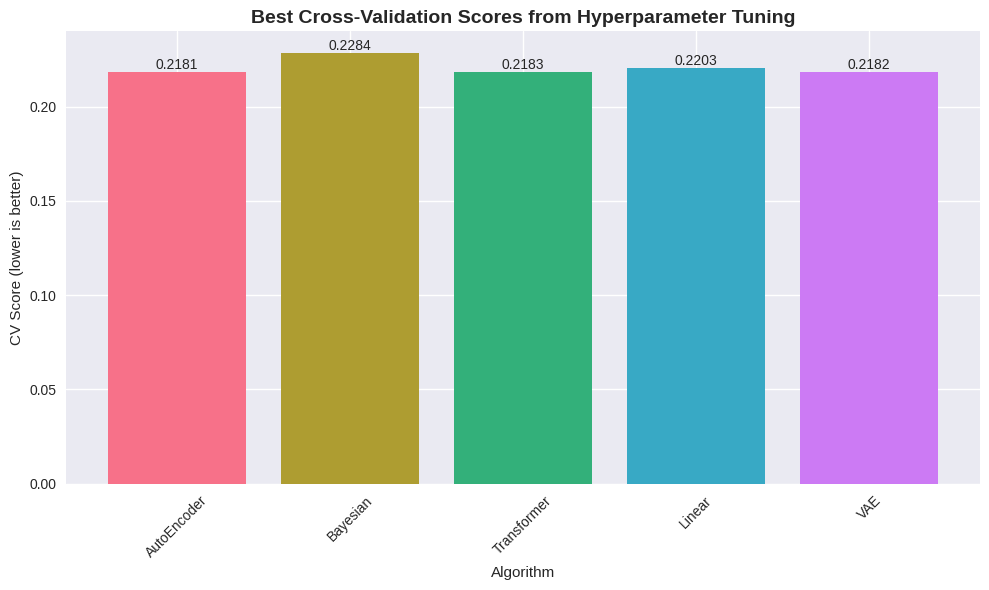

In [58]:
# Hyperparameter tuning summary
print("="*80)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*80)

# Collect all best hyperparameters and scores
hp_summary = {
    'Algorithm': [],
    'Best_CV_Score': [],
    'Best_Hyperparameters': []
}

try:
    hp_summary['Algorithm'].append('AutoEncoder')
    hp_summary['Best_CV_Score'].append(ae_best_score)
    hp_summary['Best_Hyperparameters'].append(ae_best_hyperparams)
except NameError:
    print("AutoEncoder hyperparameter tuning not completed yet.")

try:
    hp_summary['Algorithm'].append('Bayesian')
    hp_summary['Best_CV_Score'].append(bay_best_score)
    hp_summary['Best_Hyperparameters'].append(bay_best_hyperparams)
except NameError:
    print("Bayesian hyperparameter tuning not completed yet.")

try:
    hp_summary['Algorithm'].append('Transformer')
    hp_summary['Best_CV_Score'].append(trans_best_score)
    hp_summary['Best_Hyperparameters'].append(trans_best_hyperparams)
except NameError:
    print("Transformer hyperparameter tuning not completed yet.")

try:
    hp_summary['Algorithm'].append('Linear')
    hp_summary['Best_CV_Score'].append(lin_best_score)
    hp_summary['Best_Hyperparameters'].append(lin_best_hyperparams)
except NameError:
    print("Linear hyperparameter tuning not completed yet.")

try:
    hp_summary['Algorithm'].append('VAE')
    hp_summary['Best_CV_Score'].append(vae_best_score)
    hp_summary['Best_Hyperparameters'].append(vae_best_hyperparams)
except NameError:
    print("VAE hyperparameter tuning not completed yet.")

if hp_summary['Algorithm']:
    hp_df = pd.DataFrame(hp_summary)
    
    print("\nBest Cross-Validation Scores from Hyperparameter Tuning:")
    print("-" * 60)
    for _, row in hp_df.iterrows():
        print(f"{row['Algorithm']:>12}: {row['Best_CV_Score']:.6f}")
    
    print(f"\nBest performing algorithm in hyperparameter search: {hp_df.loc[hp_df['Best_CV_Score'].idxmin(), 'Algorithm']}")
    
    print("\nDetailed Best Hyperparameters:")
    print("-" * 60)
    for _, row in hp_df.iterrows():
        print(f"\n{row['Algorithm']}:")
        for key, value in row['Best_Hyperparameters'].items():
            print(f"  {key}: {value}")

    # Create visualization of hyperparameter search results
    if len(hp_summary['Algorithm']) > 1:
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(hp_df['Algorithm'], hp_df['Best_CV_Score'], 
                     color=sns.color_palette("husl", len(hp_df)))
        ax.set_title('Best Cross-Validation Scores from Hyperparameter Tuning', 
                    fontsize=14, fontweight='bold')
        ax.set_ylabel('CV Score (lower is better)')
        ax.set_xlabel('Algorithm')
        
        # Add value labels on bars
        for bar, score in zip(bars, hp_df['Best_CV_Score']):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{score:.4f}', ha='center', va='bottom')
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("No hyperparameter tuning results available yet.")

print("\n" + "="*80)

In [59]:
# Create results DataFrame
df_results = pd.DataFrame(results)

# Display results table
print("="*80)
print("ALGORITHM COMPARISON RESULTS")
print("="*80)
print(df_results.round(6))
print()

# Create summary statistics
print("SUMMARY STATISTICS:")
print("-" * 40)
print(f"Best Average Reward: {df_results['algorithm'][df_results['avg_reward'].idxmax()]} ({df_results['avg_reward'].max():.3f})")
print(f"Lowest MSE: {df_results['algorithm'][df_results['avg_mse'].idxmin()]} ({df_results['avg_mse'].min():.6f})")
print(f"Highest Success Rate: {df_results['algorithm'][df_results['success_rate'].idxmax()]} ({df_results['success_rate'].max():.3f})")
print(f"Fastest Training: {df_results['algorithm'][df_results['train_time'].idxmin()]} ({df_results['train_time'].min():.2f}s)")
print(f"Lowest Validation Loss: {df_results['algorithm'][df_results['final_val_loss'].idxmin()]} ({df_results['final_val_loss'].min():.6f})")
print()

ALGORITHM COMPARISON RESULTS
  algorithm  train_time  test_time  final_train_loss  final_val_loss  avg_mse  \
0       VAE  143.044017  47.803994          0.218203        0.214343  0.21576   

   avg_reward  success_rate  model_params  \
0  -56.984504           0.0        279586   

                                    best_hyperparams  hp_search_cv_score  
0  {'beta': 2.0, 'hidden_dim': 256, 'latent_dim':...            0.218155  

SUMMARY STATISTICS:
----------------------------------------
Best Average Reward: VAE (-56.985)
Lowest MSE: VAE (0.215760)
Highest Success Rate: VAE (0.000)
Fastest Training: VAE (143.04s)
Lowest Validation Loss: VAE (0.214343)



## Performance Visualizations

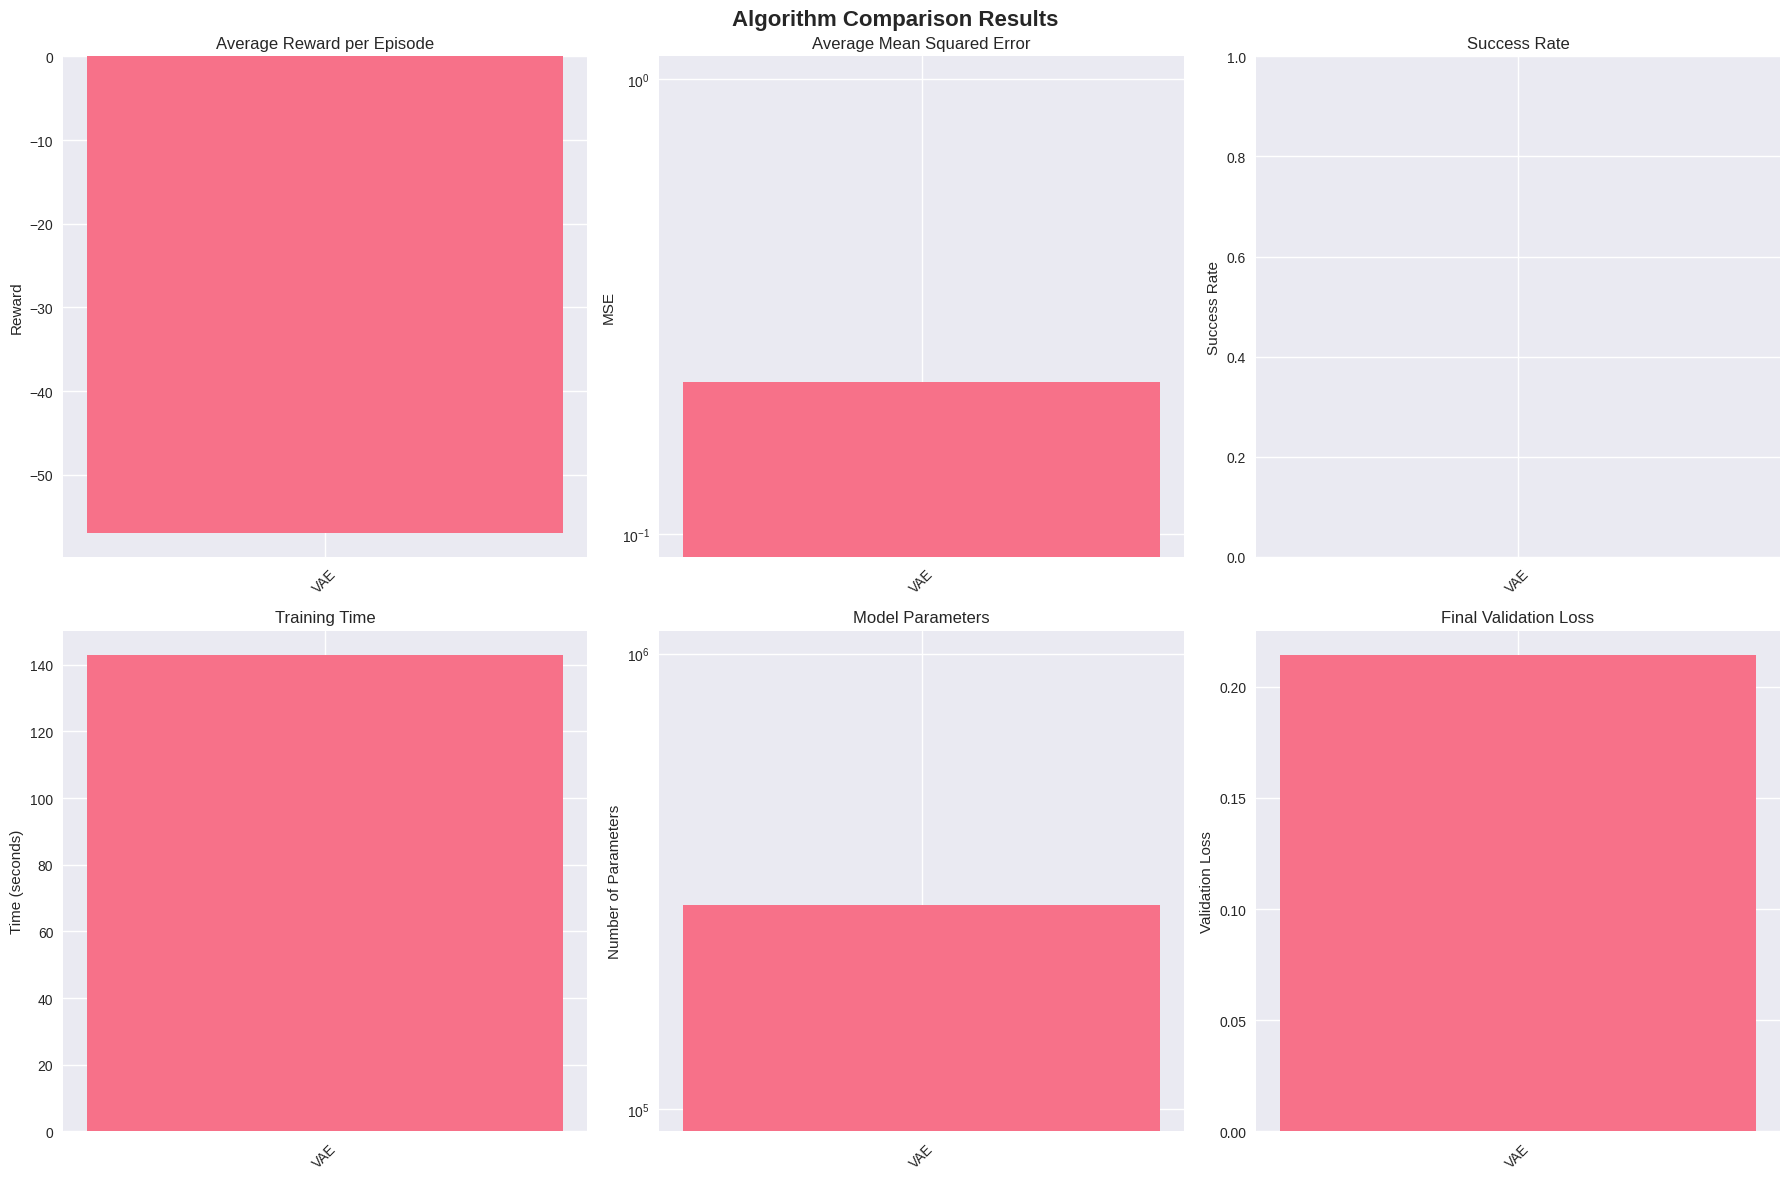

In [60]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Algorithm Comparison Results', fontsize=16, fontweight='bold')

# 1. Average Reward Comparison
axes[0, 0].bar(df_results['algorithm'], df_results['avg_reward'], color=sns.color_palette("husl", len(df_results)))
axes[0, 0].set_title('Average Reward per Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. MSE Comparison
axes[0, 1].bar(df_results['algorithm'], df_results['avg_mse'], color=sns.color_palette("husl", len(df_results)))
axes[0, 1].set_title('Average Mean Squared Error')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_yscale('log')  # Log scale for better visibility

# 3. Success Rate Comparison
axes[0, 2].bar(df_results['algorithm'], df_results['success_rate'], color=sns.color_palette("husl", len(df_results)))
axes[0, 2].set_title('Success Rate')
axes[0, 2].set_ylabel('Success Rate')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].set_ylim(0, 1)

# 4. Training Time Comparison
axes[1, 0].bar(df_results['algorithm'], df_results['train_time'], color=sns.color_palette("husl", len(df_results)))
axes[1, 0].set_title('Training Time')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Model Parameters Comparison
axes[1, 1].bar(df_results['algorithm'], df_results['model_params'], color=sns.color_palette("husl", len(df_results)))
axes[1, 1].set_title('Model Parameters')
axes[1, 1].set_ylabel('Number of Parameters')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_yscale('log')  # Log scale for better visibility

# 6. Final Validation Loss Comparison
axes[1, 2].bar(df_results['algorithm'], df_results['final_val_loss'], color=sns.color_palette("husl", len(df_results)))
axes[1, 2].set_title('Final Validation Loss')
axes[1, 2].set_ylabel('Validation Loss')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Detailed Performance Radar Chart

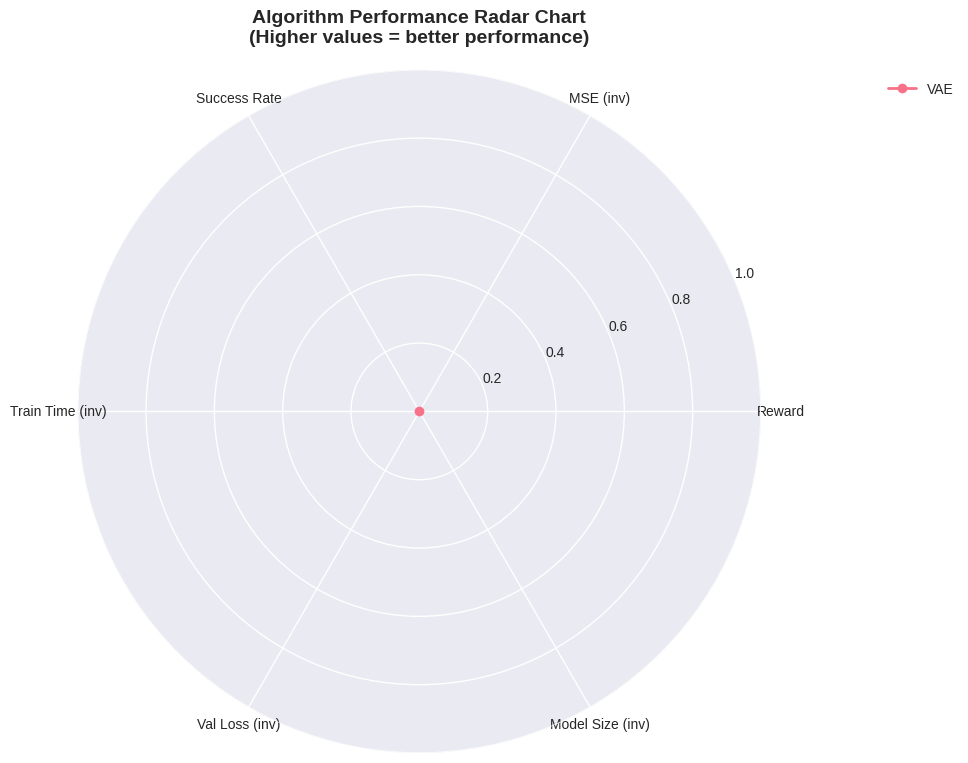

In [61]:
# Create radar chart for comprehensive comparison
def create_radar_chart(df):
    # Normalize metrics for radar chart (0-1 scale)
    normalized_df = df.copy()
    
    # For metrics where lower is better (MSE, train_time, val_loss), invert them
    normalized_df['norm_mse'] = 1 - (df['avg_mse'] - df['avg_mse'].min()) / (df['avg_mse'].max() - df['avg_mse'].min())
    normalized_df['norm_train_time'] = 1 - (df['train_time'] - df['train_time'].min()) / (df['train_time'].max() - df['train_time'].min())
    normalized_df['norm_val_loss'] = 1 - (df['final_val_loss'] - df['final_val_loss'].min()) / (df['final_val_loss'].max() - df['final_val_loss'].min())
    
    # For metrics where higher is better, normalize directly
    normalized_df['norm_reward'] = (df['avg_reward'] - df['avg_reward'].min()) / (df['avg_reward'].max() - df['avg_reward'].min())
    normalized_df['norm_success'] = df['success_rate']  # Already 0-1
    
    # Parameters normalized (smaller models get higher scores)
    normalized_df['norm_params'] = 1 - (df['model_params'] - df['model_params'].min()) / (df['model_params'].max() - df['model_params'].min())
    
    # Metrics for radar chart
    metrics = ['norm_reward', 'norm_mse', 'norm_success', 'norm_train_time', 'norm_val_loss', 'norm_params']
    metric_labels = ['Reward', 'MSE (inv)', 'Success Rate', 'Train Time (inv)', 'Val Loss (inv)', 'Model Size (inv)']
    
    # Number of metrics
    N = len(metrics)
    
    # Compute angles for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    # Create radar chart
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = sns.color_palette("husl", len(normalized_df))
    
    for i, (idx, row) in enumerate(normalized_df.iterrows()):
        values = [row[metric] for metric in metrics]
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=row['algorithm'], color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels)
    ax.set_ylim(0, 1)
    ax.set_title('Algorithm Performance Radar Chart\n(Higher values = better performance)', size=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

create_radar_chart(df_results)

## Export Results to CSV

In [62]:
# Save results to CSV with hyperparameter information
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"algorithm_comparison_results_{timestamp}.csv"

# Create a more detailed DataFrame for export
export_df = pd.DataFrame(results)

# Convert hyperparameters to string format for CSV
export_df['best_hyperparams_str'] = export_df['best_hyperparams'].apply(lambda x: str(x) if x else 'N/A')

# Save main results
export_df.to_csv(csv_filename, index=False)
print(f"Results saved to: {csv_filename}")

# Create a detailed summary report
summary_report = f"""
ALGORITHM COMPARISON SUMMARY REPORT (WITH HYPERPARAMETER TUNING)
Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
{'='*80}

EXPERIMENTAL SETUP:
- Number of training episodes: {CONFIG['num_episodes']}
- Training epochs per algorithm: {CONFIG['num_epochs']}
- Batch size: {CONFIG['batch_size']}
- Test episodes: {CONFIG['num_test_episodes']}
- Device: {CONFIG['device']}

HYPERPARAMETER TUNING SETUP:
- Search method: {CONFIG['search_method']}
- Number of trials per algorithm: {CONFIG['n_trials']}
- Cross-validation folds: {CONFIG['cv_folds']}
- Early stopping patience: {CONFIG['patience']}
- HP search epochs: {CONFIG['hp_epochs']}

RESULTS RANKING:

1. Best Overall Performance (Average Reward):
   {export_df.loc[export_df['avg_reward'].idxmax(), 'algorithm']} - {export_df['avg_reward'].max():.3f}
   Best hyperparams: {export_df.loc[export_df['avg_reward'].idxmax(), 'best_hyperparams']}

2. Most Accurate Predictions (Lowest MSE):
   {export_df.loc[export_df['avg_mse'].idxmin(), 'algorithm']} - {export_df['avg_mse'].min():.6f}
   Best hyperparams: {export_df.loc[export_df['avg_mse'].idxmin(), 'best_hyperparams']}

3. Highest Success Rate:
   {export_df.loc[export_df['success_rate'].idxmax(), 'algorithm']} - {export_df['success_rate'].max():.3f}
   Best hyperparams: {export_df.loc[export_df['success_rate'].idxmax(), 'best_hyperparams']}

4. Fastest Training:
   {export_df.loc[export_df['train_time'].idxmin(), 'algorithm']} - {export_df['train_time'].min():.2f}s
   Best hyperparams: {export_df.loc[export_df['train_time'].idxmin(), 'best_hyperparams']}

5. Best Validation Performance:
   {export_df.loc[export_df['final_val_loss'].idxmin(), 'algorithm']} - {export_df['final_val_loss'].min():.6f}
   Best hyperparams: {export_df.loc[export_df['final_val_loss'].idxmin(), 'best_hyperparams']}

6. Best Cross-Validation Score (from hyperparameter search):
   {export_df.loc[export_df['hp_search_cv_score'].idxmin(), 'algorithm']} - {export_df['hp_search_cv_score'].min():.6f}

DETAILED RESULTS:
{export_df[['algorithm', 'avg_reward', 'avg_mse', 'success_rate', 'train_time', 'hp_search_cv_score']].to_string(index=False)}

HYPERPARAMETER DETAILS:
"""

for _, row in export_df.iterrows():
    summary_report += f"""
{row['algorithm']}:
  Best hyperparameters: {row['best_hyperparams']}
  HP search CV score: {row['hp_search_cv_score']:.6f}
  Final validation loss: {row['final_val_loss']:.6f}
  Model parameters: {row['model_params']:,}
"""

summary_report += f"""

RECOMMENDATIONS:
- For real-time applications: Choose the algorithm with fastest training/inference
- For accuracy-critical tasks: Choose the algorithm with lowest MSE
- For exploration tasks: Choose the algorithm with highest success rate
- For resource-constrained environments: Choose the algorithm with fewest parameters
- For robust performance: Consider the algorithm with best cross-validation score

METHODOLOGY NOTES:
- All algorithms underwent {CONFIG['cv_folds']}-fold cross-validation hyperparameter tuning
- Best hyperparameters were selected based on validation loss minimization
- Final models were trained with full epochs using the best hyperparameters
- This ensures fair comparison and optimal performance for each algorithm
"""

# Save summary report
summary_filename = f"algorithm_comparison_summary_{timestamp}.txt"
with open(summary_filename, 'w') as f:
    f.write(summary_report)

print(f"Summary report saved to: {summary_filename}")
print("\nSummary Report:")
print(summary_report)

Results saved to: algorithm_comparison_results_20251010_203904.csv
Summary report saved to: algorithm_comparison_summary_20251010_203904.txt

Summary Report:

ALGORITHM COMPARISON SUMMARY REPORT (WITH HYPERPARAMETER TUNING)
Generated on: 2025-10-10 20:39:04

EXPERIMENTAL SETUP:
- Number of training episodes: 1000
- Training epochs per algorithm: 700
- Batch size: 128
- Test episodes: 50
- Device: cuda

HYPERPARAMETER TUNING SETUP:
- Search method: grid
- Number of trials per algorithm: 10
- Cross-validation folds: 3
- Early stopping patience: 3
- HP search epochs: 50

RESULTS RANKING:

1. Best Overall Performance (Average Reward):
   VAE - -56.985
   Best hyperparams: {'beta': 2.0, 'hidden_dim': 256, 'latent_dim': 16, 'lr': 0.01}

2. Most Accurate Predictions (Lowest MSE):
   VAE - 0.215760
   Best hyperparams: {'beta': 2.0, 'hidden_dim': 256, 'latent_dim': 16, 'lr': 0.01}

3. Highest Success Rate:
   VAE - 0.000
   Best hyperparams: {'beta': 2.0, 'hidden_dim': 256, 'latent_dim': 16, '